# Generate training data

256×169 samples</p>
### Change demand
timestep = 1h, 1 week ->169 timesteps in total</p>
at every timestep, change the nodal demand</p>
### Change topology
Randomly cut the connectivity between two pipes, but preserving the connectivity between each node in the network and source. ->256 topology

### Try single timestep

In [1]:
import wntr
import networkx as nx
import scipy.sparse as sp
import numpy as np 
import random
import tqdm
import os 
import matplotlib.pyplot as plt
import itertools
from collections import Counter 
import networkx as nx
import copy
import pandas as pd
import tensorflow_gnn as tfgnn
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
def get_removable_links(inp_file):
    wn = wntr.network.WaterNetworkModel(inp_file)
    removable_links = []
    G = wn.to_graph(wn)
    # Store not-deadend pipes to be removed
    for _, link in wn.links():
        if (link.link_type == 'Pipe' and
            link.start_node.node_type == 'Junction' and
            link.end_node.node_type == 'Junction' and
            G.degree[link.start_node.name] > 1 and
            G.degree[link.end_node.name] > 1):
            removable_links.append(link)
    # To find pairs of links that can be removed together while keeping the network graph connected
    removable_pairs = []
    for (link1, link2) in itertools.combinations(removable_links, 2):
        wnr = copy.deepcopy(wn)  #create a new reference to the same object
        wnr.remove_link(link1)
        wnr.remove_link(link2)
        Gr = wnr.to_graph().to_undirected()
        if nx.is_connected(Gr):
            removable_pairs.append((link1, link2))

    return removable_links, removable_pairs


In [3]:
network = 'ASnet2'
inp_file = network + '.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# get removable links
removable_links, removable_pairs = get_removable_links(inp_file)
num_nodes = wn.num_nodes
num_links = wn.num_links
num_time = int(wn.options.time.duration / wn.options.time.report_timestep + 1)

In [10]:
n_sims = 128
#𝑉_𝑖=[ 𝐼_𝑖^𝑑, 𝑞_𝑖, 𝐼_𝑖^𝑚,𝐻_𝑖^∗ ] 
#𝐸_𝑝=[𝑖,𝑗,𝑐_𝑝]
#Create data matrix
A = np.zeros((n_sims , num_links*num_time, 3))
B = np.zeros((n_sims , num_nodes*num_time, 6))
U = np.zeros((n_sims , num_nodes*num_time, 1))

# Store the randomly chosen pairs of removable links
links2remove = random.sample(removable_pairs, n_sims)

## Measurement when fully-supervised
monitor = [ '5', '11', '32', '37', '51']

In [12]:
for sim in range(n_sims):
    wn = wntr.network.WaterNetworkModel(inp_file)  # reset value
    wn.options.hydraulic.demand_model = 'DD' #dynamic demand model

    i = 0
    for _, node in wn.nodes():
        node.id = i
        i += 1

    if sim != 0:
        (link1, link2) = links2remove[sim - 1]
        wn.remove_link(link1)
        wn.remove_link(link2)

    i = 0
    for _, link in wn.links():
        A[sim, i, 0] = link.start_node.id
        A[sim, i, 1] = link.end_node.id
        if link.link_type=='Pipe':
            A[sim, i, 2] = 1/(10.667*link.length/link.roughness**1.852/link.diameter**4.871)
            i+=1
        elif link.link_type=='Pump':
            A[sim, i, 2] = 1        
        elif link.link_type=='Valve':
            A[sim, i, 2] = 2        
        else:
            print('Other types of links exist.')
        i+=1

    results = wntr.sim.EpanetSimulator(wn).run_sim(version=2.0)
    head = results.node['head']
    demand = results.node['demand']
    demand = np.maximum(demand, 0)

    ### Produce datas for multiple timestep
    #### Time step
    index_values = head.index.values
    np.random.seed(42)
    Time_step = np.random.choice(index_values, size=num_time, replace=False)
    
    repeated_timestep = pd.Series(Time_step).repeat(num_nodes).reset_index(drop=True)
    Time_indicator = pd.DataFrame({'Timestep': repeated_timestep})
    Time_indicator = Time_indicator.squeeze()
    
    #### Demand
    demand_s = demand.loc[Time_step]
    demand_s = demand_s.values.flatten()
    #### Head
    head_s = head.loc[Time_step]
    head_s = head_s.values.flatten()
    #### Node indicator (the number of the node)
    Node_indicator = np.tile(np.arange(1, num_nodes+1), num_time)
        # Measurement when fully-supervised
    measurement_fully = Node_indicator
    #### Junction indicator (if the node is not a reservoir, junction indicator = 1)
    Nd_single = np.array([1 if node.node_type == 'Junction' else 0 for _, node in wn.nodes()])
    Nd = np.tile(Nd_single,num_time)
    Nd = Nd.squeeze()
    #### Measurement indicator (if the node has head, measurement indicator = 0) 
    Nh_single = np.array([0 if node.node_type=='Junction' and node.name not in monitor else 1 for _,node in wn.nodes()])
    Nh = np.tile(Nh_single,num_time)
    Nh = Nh.squeeze()
    
    
    ### Node
    B[sim, :, 0] = Time_indicator
    B[sim, :, 1] = Node_indicator
    B[sim, :, 2] = Nd
    B[sim, :, 3] = demand_s
    B[sim, :, 4] = Nh
    B[sim, :, 5] = Nh* head_s
    ###

    U[sim, :, 0] = head_s

In [13]:
### Edge
A_re = A[:, :num_links, :]  # Extract the first 65 rows along the second axis

# Repeat the 65 rows to cover the entire second axis
A_re = np.tile(A_re, (1, num_time, 1))


### Change 3-d array to DataFrame

In [14]:
array_3d_shape = B.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
B_2d = B.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
node_df = pd.DataFrame(B_2d)

array_3d_shape = A_re.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
A_2d = A_re.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
edge_df = pd.DataFrame(A_2d)

array_3d_shape = U.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
U_2d = U.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
graph_df = pd.DataFrame(U_2d)

In [15]:
graph_df.rename(columns={0: 'head'},inplace=True)
edge_df.rename(columns={0: 'source', 1: 'target', 2: 'loss_co'},inplace=True)
node_df.rename(columns={0:'Time_indicator', 1: 'Node_indicator', 2:'Junction_in',3: 'demand', 4: 'Measurement_in',5:'measurement'},inplace=True)

## Scale the data

In [16]:
test_edge_df = edge_df[n_sims * num_links * (num_time - 34):]
test_node_df = node_df[n_sims * num_nodes * (num_time - 34):]
test_graph_df = graph_df[n_sims * num_nodes * (num_time - 34):]

train_edge_df = edge_df[:n_sims * num_links * (num_time - 100)]
train_node_df = node_df[:n_sims * num_nodes * (num_time - 100)]
train_graph_df = graph_df[:n_sims * num_nodes * (num_time - 100)]

vali_edge_df = edge_df[n_sims * num_links * (num_time - 67):n_sims * num_links * (num_time - 34)]
vali_node_df = node_df[n_sims * num_nodes * (num_time - 67):n_sims * num_nodes * (num_time - 34)]
vali_graph_df = graph_df[n_sims * num_nodes * (num_time - 67):n_sims * num_nodes * (num_time - 34)]

In [17]:
def create_graph_tensor(node_df, edge_df):
    graph_tensor = tfgnn.GraphTensor.from_pieces(

        node_sets={
            "node": tfgnn.NodeSet.from_fields(
                sizes=[len(node_df)],
                features={
                   # 'Node_indicator':np.array(node_df['Node_indicator'], dtype='int32').reshape(len(node_df),1),
                    'Junction_in':np.array(node_df['Junction_in'], dtype='int32').reshape(len(node_df),1),
                    'demand': np.array(node_df['demand'], dtype='float32').reshape(len(node_df),1),
                    'Measurement_in': np.array(node_df['Measurement_in'], dtype='int32').reshape(len(node_df),1),
                    'measurement': np.array(node_df['measurement'], dtype='float32').reshape(len(node_df),1),
                }
            )
        },
        edge_sets={
            "link": tfgnn.EdgeSet.from_fields(
                sizes=[len(edge_df)],
                features={
                    'loss_co': np.array(edge_df['loss_co'], dtype='float32').reshape(len(edge_df),1),
                },
                adjacency=tfgnn.Adjacency.from_indices(
                                          source=("node", np.array(edge_df['source'], dtype='int32')),
                                          target=("node", np.array(edge_df['target'], dtype='int32')),
                                      ))
        }
    )

    return graph_tensor


In [18]:
full_tensor = create_graph_tensor(node_df, edge_df)
train_tensor = create_graph_tensor(train_node_df, train_edge_df)
test_tensor = create_graph_tensor(test_node_df, test_edge_df)
vali_tensor = create_graph_tensor(vali_node_df, vali_edge_df)

split off ‘head’ as our target (label).

In [19]:
def node_batch_merge(graph):
    graph = graph.merge_batch_to_components()
    node_features = graph.node_sets['node'].get_features_dict()
    edge_features = graph.edge_sets['link'].get_features_dict()
    
    label = node_features.pop('measurement')
    print(label)
    new_graph = graph.replace_features(node_sets={'node': node_features}, edge_sets={'link': edge_features})
    
    return new_graph, label


     
def create_dataset(graph, function):
    dataset = tf.data.Dataset.from_tensors(graph)
    dataset = dataset.batch(32)
    return dataset.map(function)

### Train dataset

In [20]:
full_node_dataset = create_dataset(full_tensor, node_batch_merge)
train_node_dataset = create_dataset(train_tensor, node_batch_merge)
test_node_dataset = create_dataset(test_tensor, node_batch_merge)
vali_node_dataset = create_dataset(vali_tensor, node_batch_merge)

Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)


# Model Building

## Build model inputs

In [21]:
graph_spec = train_node_dataset.element_spec[0]
input_graph = tf.keras.layers.Input(type_spec=graph_spec)

In [22]:
def set_initial_node_state(node_set, node_set_name):
    features = [
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['Junction_in']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['demand']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['Measurement_in']),
    ]
    return tf.keras.layers.Concatenate()(features)


def set_initial_edge_state(edge_set, edge_set_name):
    features = [
        tf.keras.layers.Dense(32, activation="leaky_relu")(edge_set['loss_co']),
    ]
    return tf.keras.layers.Concatenate()(features)




In [23]:
graph = tfgnn.keras.layers.MapFeatures(node_sets_fn=set_initial_node_state,
                                       edge_sets_fn=set_initial_edge_state)(input_graph)

In [24]:
def dense_layer(units=32, l2_reg=5e-4, dropout=0.25, activation='tf.nn.leaky_relu'):
    regularizer = tf.keras.regularizers.l2(l2_reg)
    return tf.keras.Sequential([
        tf.keras.layers.Dense(units, kernel_initializer='glorot_normal',kernel_regularizer=regularizer, bias_regularizer=regularizer),
        tf.keras.layers.Dropout(dropout)
    ])


### Compile

In [25]:
graph_updates = 6
l2_reg = 5e-4
regularizer = tf.keras.regularizers.l2(l2_reg)
for i in range(graph_updates):
    graph = tfgnn.keras.layers.GraphUpdate(
        node_sets={
            'node':
            tfgnn.keras.layers.NodeSetUpdate(
                {
                    'link':
                    tfgnn.keras.layers.SimpleConv(message_fn=dense_layer(128),
                                                  reduce_type="mean",
                                                  sender_edge_feature=tfgnn.HIDDEN_STATE,
                                                  receiver_tag=tfgnn.TARGET)
                }, tfgnn.keras.layers.NextStateFromConcat(dense_layer(64)))
        })(graph)
    dense1 = tf.keras.layers.Dense(128,activation=tf.nn.leaky_relu)(graph.node_sets["node"][tfgnn.HIDDEN_STATE])
    dense2 = tf.keras.layers.Dense(64)(dense1)
    dense3 = tf.keras.layers.Dense(1)(dense2)

In [66]:
def custom_loss_builder(loss_co, source_indices, target_indices):
    
   
    def flow_imbalance_metric(y_true, y_pred):

        num_samples = tf.shape(y_pred)[0]
        num_time_steps = 96
        nodes_per_time_step = tf.shape(y_pred)[1] // num_time_steps
        total_flow_imbalance = tf.constant(0, dtype=tf.float32)

        
        for i in range(num_samples):
            for t in range(num_time_steps):
                start_idx = t * nodes_per_time_step
                end_idx = (t + 1) * nodes_per_time_step

                predicted_demand = y_pred[i, start_idx:end_idx]
                true_demand = y_true[i, start_idx:end_idx]

                source_flow = tf.gather(predicted_demand, source_indices)
                target_flow = tf.gather(predicted_demand, target_indices)

                flow_difference = source_flow - target_flow
                flow_imbalance = tf.reduce_sum(flow_difference * loss_co)

                total_flow_imbalance += flow_imbalance

        return total_flow_imbalance / tf.cast(num_samples * num_time_steps, tf.float32)


 
    def custom_loss(y_true, y_pred):
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        flow_imbalance = flow_imbalance_metric(y_true, y_pred)
        return mse + flow_imbalance
    
    return custom_loss


loss_co = edge_df['loss_co']  
source_indices = edge_df['target']  
target_indices = edge_df['source']  
source_indices = source_indices.astype(np.int32)
target_indices = target_indices.astype(np.int32)

custom_loss = custom_loss_builder(loss_co, source_indices, target_indices)


In [68]:
node_model = tf.keras.Model(input_graph, dense3)
node_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                   loss=custom_loss,
                   metrics=['mean_squared_error'])
node_model.summary()


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [()]                      0         
                                                                 
 map_features (MapFeatures)  ()                        256       
                                                                 
 graph_update (GraphUpdate)  ()                        43200     
                                                                 
 graph_update_1 (GraphUpdate  ()                       32960     
 )                                                               
                                                                 
 graph_update_2 (GraphUpdate  ()                       32960     
 )                                                               
                                                                 
 graph_update_3 (GraphUpdate  ()                       329

### Train model

In [69]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      patience=10,
                                      restore_best_weights=True)

node_model.fit(train_node_dataset.repeat(),
               validation_data=vali_node_dataset,
               steps_per_epoch=10,
               epochs=200,
               callbacks=[es])

Epoch 1/200


StagingError: in user code:

    File "C:\Users\TianZhang\anaconda3\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\TianZhang\anaconda3\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\TianZhang\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\TianZhang\anaconda3\lib\site-packages\keras\engine\training.py", line 1054, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\TianZhang\anaconda3\lib\site-packages\keras\optimizers\optimizer.py", line 542, in minimize
        grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "C:\Users\TianZhang\anaconda3\lib\site-packages\keras\optimizers\optimizer.py", line 275, in compute_gradients
        grads = tape.gradient(loss, var_list)

    MemoryError: 


### Evaluate model

In [24]:
eval_result = node_model.evaluate(test_node_dataset)
print(dict(zip(node_model.metrics_names, eval_result)))

1/1 [==============================] - 1s 960ms/step - loss: 37.1964 - mean_squared_error: 36.7043
{'loss': 37.19643783569336, 'mean_squared_error': 36.70433807373047}


In [25]:
predictions = pd.DataFrame(node_model.predict(full_node_dataset))
print(predictions)

1/1 [==============================] - 5s 5s/step
                  0
0         -2.249367
1         -2.334319
2         -2.289788
3         -2.207314
4        364.931274
...             ...
1103227   -1.038508
1103228   -1.043775
1103229   -1.043775
1103230   -1.043775
1103231  385.183868

[1103232 rows x 1 columns]


In [26]:
predictions.to_csv('predictions_SEMI_small.csv')

In [27]:
residuals =  graph_df['head']- predictions[0]

In [30]:
ana = pd.DataFrame({
    'node':node_df['Node_indicator'],
    'mea_in':node_df['Measurement_in'],
    'predictions': predictions[0],
    'residuals': residuals
})
ana.head()

,node,mea_in,predictions,residuals
0,1.0,0.0,-2.249367,400.047982
1,2.0,0.0,-2.334319,400.132324
2,3.0,0.0,-2.289788,400.088250
3,4.0,0.0,-2.207314,400.012979
4,5.0,1.0,364.931274,32.868744


In [62]:
float_monitor = [float(num_str) for num_str in monitor]
RESI = ana[ana['node'].isin(float_monitor)]['residuals']
PRE = ana[ana['node'].isin(float_monitor)]['predictions']

In [65]:
RESI =  np.array(RESI).reshape((-1, 5,128))
RESI = np.mean(RESI, axis=2)
RESI= pd.DataFrame(RESI, columns=['Node ' + str(i) for i in float_monitor])


In [33]:
PRE =  np.array(PRE).reshape((-1, 5,128))
PRE = np.mean(PRE, axis=2)
PRE= pd.DataFrame(PRE, columns=['Node ' + str(i) for i in float_monitor])

In [36]:
PRE

,Node 5.0,Node 11.0,Node 32.0,Node 37.0,Node 51.0
0,378.925751,379.171295,379.113861,379.175049,379.170624
3600,379.115936,379.174500,379.114532,379.171936,379.172852
7200,379.114441,379.173920,379.113983,379.175049,379.172607
10800,379.113708,379.174500,379.112488,379.175720,379.172516
14400,379.115051,379.173340,379.112671,379.173340,379.173645
...,...,...,...,...,...
590400,379.112946,379.173096,379.113983,379.174255,379.172882
594000,379.116119,379.172699,379.113342,379.174988,379.171204
597600,379.116760,379.172668,379.114685,379.173645,379.171570
601200,379.114227,379.173828,379.114136,379.176453,379.171997


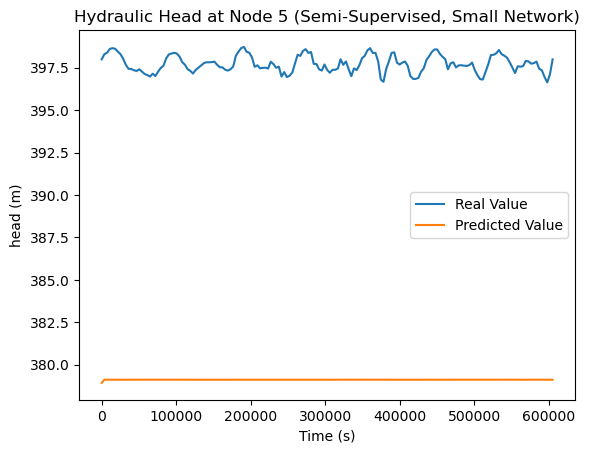

In [37]:
head_at_node5 = head.loc[:,'5']
ax = head_at_node5.plot()
ax.set_xlabel("Time (s)")
ax.set_ylabel("head (m)")
PRE = PRE.set_index(head.index)

PRE['Node 5.0'].plot(ax=ax)
plt.title('Hydraulic Head at Node 5 (Semi-Supervised, Small Network)')
plt.legend(['Real Value', 'Predicted Value'])
plt.savefig('Hydraulic Head at Node 5 (Semi-Supervised, Small Network).png')
plt.show()

In [52]:
RESI

,Node 5.0,Node 11.0,Node 32.0,Node 37.0,Node 51.0
0,19.041379,18.987505,18.970446,18.844393,18.988813
1,18.902872,18.843486,18.929808,18.996829,18.893859
2,18.947535,18.872329,18.968829,18.837689,18.913648
3,18.997114,18.841794,19.004459,18.823830,18.936853
4,18.909450,18.905344,19.012646,18.894188,18.890025
...,...,...,...,...,...
164,19.048027,18.889381,18.955707,18.872303,18.913961
165,18.884287,18.914072,19.002376,18.840307,18.953661
166,18.872194,18.938374,18.910863,18.909033,18.957659
167,18.950671,18.887369,18.956882,18.780883,18.931863


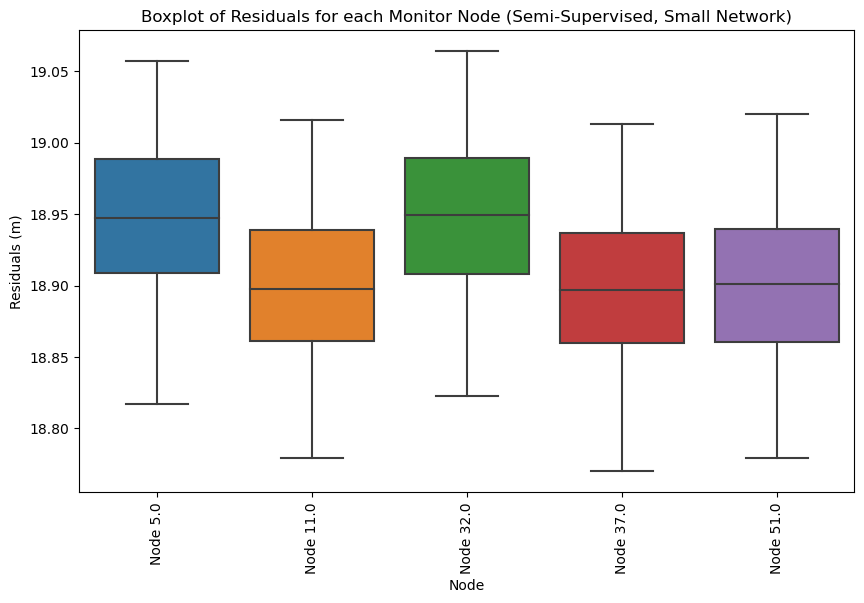

In [41]:
plt.figure(figsize=(10, 6))  
sns.boxplot(data=RESI)
plt.xlabel('Node')
plt.ylabel('Residuals (m)')
plt.title('Boxplot of Residuals for each Monitor Node (Semi-Supervised, Small Network)')


plt.xticks(rotation=90)
plt.xticks(range(len(RESI.columns)), RESI.columns, rotation=90)

# Show the plot
plt.savefig('Boxplot of Residuals for each Node (Semi-Supervised, Small Network).png')
plt.show()

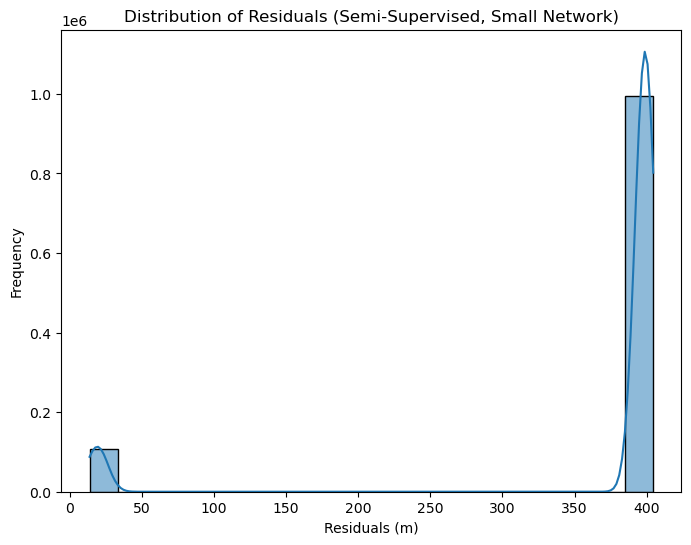

In [42]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.histplot(residuals, kde=True, bins=20)  # kde=True adds a Kernel Density Estimation curve
plt.xlabel('Residuals (m)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.title('Distribution of Residuals (Semi-Supervised, Small Network)')
plt.savefig('Distribution of Residuals (Semi-Supervised, Small Network).png')
plt.show()

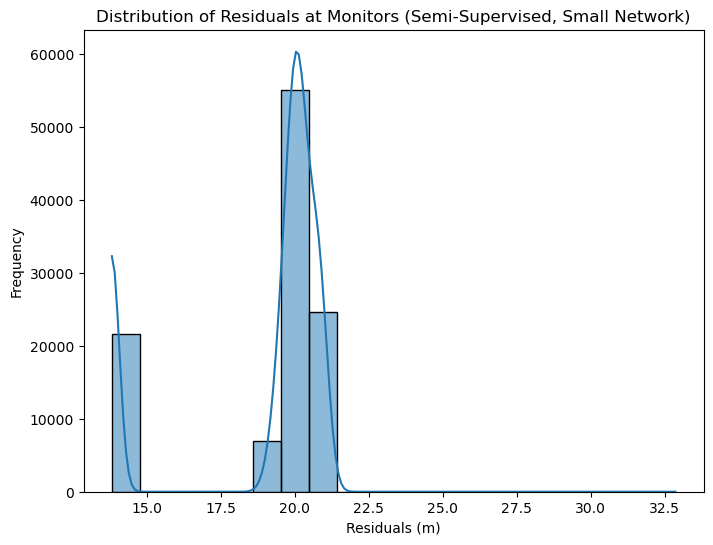

In [64]:

plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.histplot(RESI, kde=True, bins=20)  # kde=True adds a Kernel Density Estimation curve
plt.xlabel('Residuals (m)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals at Monitors (Semi-Supervised, Small Network)')

plt.savefig('Distribution of Residuals at Monitors (Semi-Supervised, Small Network)0.png')
plt.show()

In [55]:
RESI.min()

13.816162109375

In [56]:
RESI.max()

32.868743896484375

In [57]:
residuals.min()

13.816162109375

In [58]:
residuals.max()

404.5019316673279

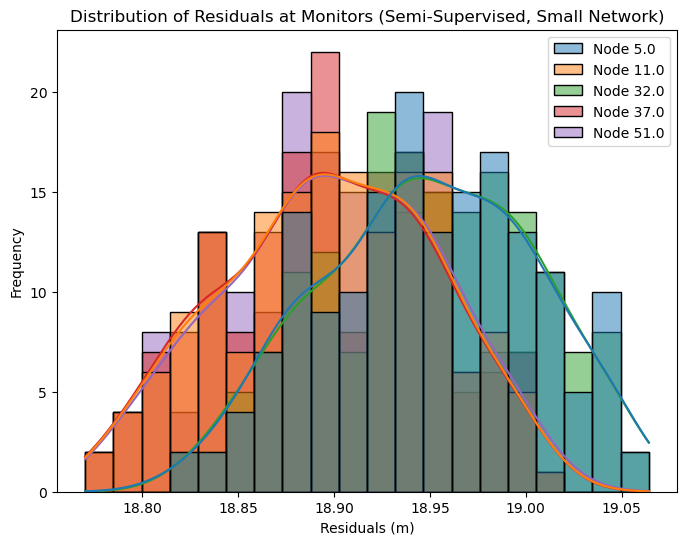

In [66]:

plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.histplot(RESI, kde=True, bins=20)  # kde=True adds a Kernel Density Estimation curve
plt.xlabel('Residuals (m)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals at Monitors (Semi-Supervised, Small Network)')

plt.savefig('Distribution of Residuals at Monitors (Semi-Supervised, Small Network)1.png')
plt.show()